# Stimulation Specific Between-subject Similarity Analysis

## Import Libraries and Load Data

In [1]:
import os
import math
from functools import partial
from itertools import combinations_with_replacement, permutations, product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import analysis_toolkit as toolkit

generate_dirname = "./Generate"
os.makedirs(generate_dirname, exist_ok=True)
dataset = toolkit.dataset.Dataset("./Dataset")

## Definition

In [2]:
def datatype_and_stimulations():
    for data_type in dataset.data_types:
        for stim in dataset.stimulations:
            yield data_type, stim, dataset.subject_idx_lst(data_type=data_type, stimulation=stim)

## Get Basic Information of the Dataset

In [3]:
basic_info_df = pd.DataFrame(
    columns=[
        "Region",
        "DataType",
        "Stimulation",
        "NumberOfSubjects",
        "Mean",
        "Std",
        "0%",
        "25%",
        "50%",
        "75%",
        "100%",
    ]
)
format_info = lambda x: f"{x:.2f}"
for region in dataset.regions:
    for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
        data = []
        for subject_idx in subject_idx_lst:
            subject_data = dataset.get_region_data(
                subject_idx=subject_idx, region=region
            )
            data.append(subject_data)
        data = np.stack(data, axis=0)
        new_row = pd.Series(
            {
                "Region": region,
                "DataType": data_type,
                "Stimulation": stimulation,
                "NumberOfSubjects": len(subject_idx_lst),
                "Mean": format_info(np.nanmean(data)),
                "Std": format_info(np.nanstd(data)),
                "0%": format_info(np.nanmin(data)),
                "25%": format_info(np.nanpercentile(data, 25)),
                "50%": format_info(np.nanpercentile(data, 50)),
                "75%": format_info(np.nanpercentile(data, 75)),
                "100%": format_info(np.nanmax(data)),
            }
        )
        basic_info_df = pd.concat([basic_info_df, new_row.to_frame().T], ignore_index=True)
basic_info_df.to_csv(os.path.join(generate_dirname, "basic_info.csv"), index=False)

## z=15 Section

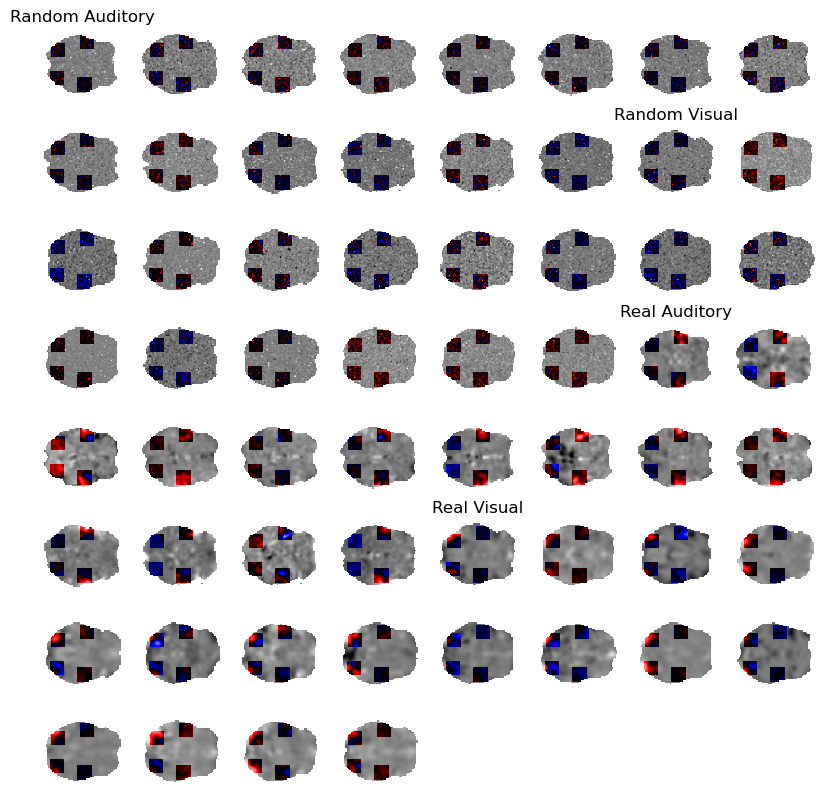

In [4]:
FIGSIZE = (10, 10)

with plt.style.context("default"):
    fig = plt.figure(figsize=FIGSIZE)
    ax_idx = 1
    total_idx = len(dataset.database)
    nrows = math.ceil(total_idx ** 0.5)
    ncols = math.ceil(total_idx / nrows)
    for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
        for subject_idx in subject_idx_lst:
            subject = dataset.database.loc[subject_idx, "subject"]
            ax = fig.add_subplot(nrows, ncols, ax_idx)
            mask = []
            for region in dataset.regions:
                mask.append(dataset.get_region_mask(region=region))
            mask = np.stack(mask, axis=0)
            mask = np.any(mask, axis=0)
            if subject.endswith("01"):
                title = f"{data_type} {stimulation}"
            else:
                title = ""
            data = dataset.get_whole_brain_data(subject_idx=subject_idx)
            ax = toolkit.plot.plot_brain(data=data, 
                                         axis="z", 
                                         idx=15,
                                         ax=ax,
                                         title=title,
                                         roi_mask=mask,)
            ax_idx += 1
    plt.show(fig)
    fig.savefig(os.path.join(generate_dirname, "brain_sections_z_15.svg"))

## PCA

### 3D

/home/kellan/WorkSpace/Projects/Institution/UM/202401/stimulation_specific_between-subject_similarity/analysis_toolkit/_plot.py:194: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(v[:, 0], v[:, 1], v[:, 2], c=colors(color_idx), label=k)
/home/kellan/WorkSpace/Projects/Institution/UM/202401/stimulation_specific_between-subject_similarity/analysis_toolkit/_plot.py:217: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/home/kellan/WorkSpace/Projects/Institution/UM/202401/stimulation_specific_between-subject_similarity/analysis_toolkit/_plot.py:220: UserWarning: set_ticklabels() should only be used w

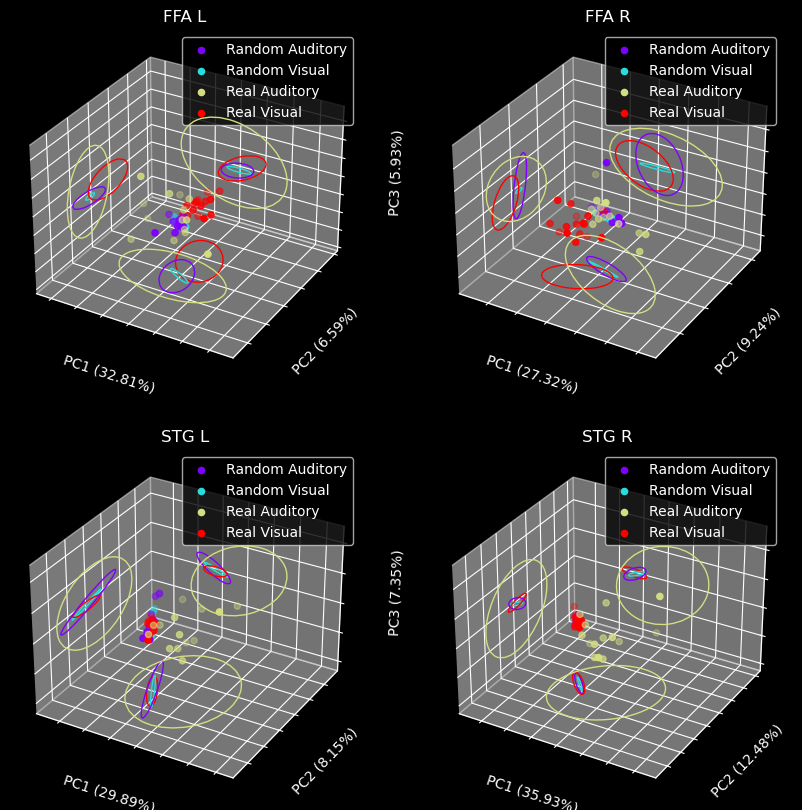

In [5]:
FIGSIZE = (10, 10)

with plt.style.context("dark_background"):
    fig = plt.figure(figsize=FIGSIZE)
    for ax_idx, region in enumerate(dataset.regions, start=1):
        pca_dict = {}
        for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
            data = []
            for subject_idx in subject_idx_lst:
                subject_data = dataset.get_region_data(
                    subject_idx=subject_idx, region=region
                )
                data.append(subject_data)
            pca_dict[f"{data_type} {stimulation}"] = data
        pca_dict, pca = toolkit.pca.pca_decomposition_3d(data_dict=pca_dict)
        ax = fig.add_subplot(2, 2, ax_idx, projection='3d')
        ax = toolkit.plot.plot_pca_3d(data_dict=pca_dict, 
                                    title=region, 
                                    ax=ax, 
                                    confidence_level=0.95, 
                                    ticks=False, 
                                    legend=True)
        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
        ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.2%})")
    plt.show(fig)
    fig.savefig(os.path.join(generate_dirname, "pca_3d.svg"))

### 2D

/home/kellan/WorkSpace/Projects/Institution/UM/202401/stimulation_specific_between-subject_similarity/analysis_toolkit/_plot.py:136: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(v[:, 0], v[:, 1], c=colors(color_idx), label=k)
/home/kellan/WorkSpace/Projects/Institution/UM/202401/stimulation_specific_between-subject_similarity/analysis_toolkit/_plot.py:136: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(

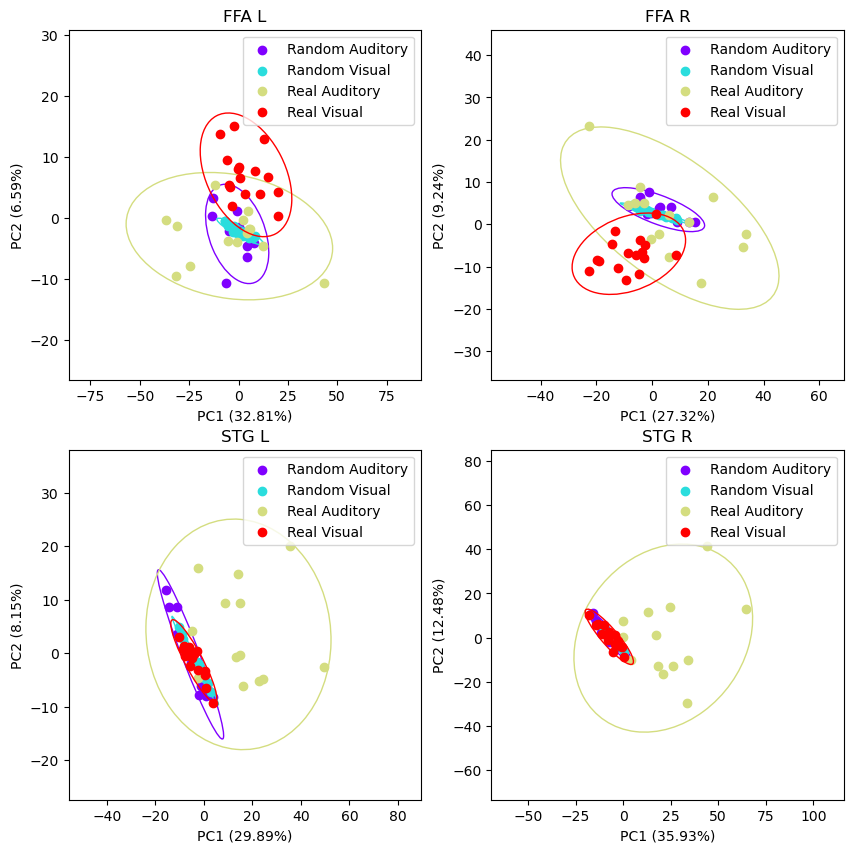

In [6]:
FIGSIZE = (10, 10)

with plt.style.context("default"):
    fig = plt.figure(figsize=FIGSIZE)
    for ax_idx, region in enumerate(dataset.regions, start=1):
        pca_dict = {}
        for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
            data = []
            for subject_idx in subject_idx_lst:
                subject_data = dataset.get_region_data(
                    subject_idx=subject_idx, region=region
                )
                data.append(subject_data)
            pca_dict[f"{data_type} {stimulation}"] = data
        pca_dict, pca = toolkit.pca.pca_decomposition_2d(data_dict=pca_dict)
        ax = fig.add_subplot(2, 2, ax_idx)
        ax = toolkit.plot.plot_pca_2d(data_dict=pca_dict, 
                                    title=region, 
                                    ax=ax, 
                                    confidence_level=0.95, 
                                    ticks=True, 
                                    legend=True)
        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
    plt.show(fig)
    fig.savefig(os.path.join(generate_dirname, "pca_2d.svg"))

## Between Subject Similarity

### Definition

In [7]:
def yield_idx():
    idx = 0
    for *_, subject_idx_lst in datatype_and_stimulations():
        for subject_idx in subject_idx_lst:
            yield idx, subject_idx
            idx += 1

def get_slices():
    idx = 0
    sclices = {}
    for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
        sclices[f"{data_type} {stimulation}"] = slice(idx, idx + len(subject_idx_lst))
        idx += len(subject_idx_lst)
    return sclices

### Get Similarity Matrix Dictionary

In [8]:
func_name_lst = ["cosine_similarity", 
                 "pearson_correlation_coefficient",]
func_dict = {}
for func_name in func_name_lst:
    title = func_name.replace("_", " ").title()
    func = getattr(toolkit.similarity, func_name)
    func_dict[title] = func
    if (func_name == "pearson_correlation_coefficient") or (func_name == "cosine_similarity"):
        for preprocess_method in ["FFT", "Gradient", "Spatial Average"]:
            preprocessed_func = partial(
                func,
                preprocess_method=preprocess_method)
            func_dict[f"{preprocess_method} + {title}"] = preprocessed_func

similarity_mat_dict = {}
for title, func in func_dict.items():
    region_dict = {}
    for region in dataset.regions:
        get_data = partial(dataset.get_region_data, region=region)
        mat = np.empty((len(dataset.database),) * 2)
        subject_vectors = {}
        for (idx_1, subject_idx_1), (idx_2, subject_idx_2) in combinations_with_replacement(
            yield_idx(), 2):
            # print(f"idx: {idx_1, idx_2}\nsubject_idx: {subject_idx_1, subject_idx_2}")
            data_1 = get_data(subject_idx=subject_idx_1)
            data_2 = get_data(subject_idx=subject_idx_2)
            mat[idx_1, idx_2] = func(data_1, data_2)
            mat[idx_2, idx_1] = mat[idx_1, idx_2]
        for idx, subject_idx in yield_idx():
            get_info = lambda info: dataset.database.loc[subject_idx, info]
            subject_vector = toolkit.dataset.SubjectSimilarityVector(
                subject_idx=subject_idx,
                data_type=get_info("data_type"),
                stimulation=get_info("stimulation"),
                structure=toolkit.dataset.get_structure(region=region),
                hemisphere=toolkit.dataset.get_hemisphere(region=region),
                subject=get_info("subject"),
                idx=idx,
                similarity_vector=mat[idx],
            )
            subject_vectors[subject_idx] = subject_vector
        similarity_mat = toolkit.dataset.SimilarityMatrix(
            matrix=mat, 
            region=region, 
            structure=toolkit.dataset.get_structure(region=region),
            hemisphere=toolkit.dataset.get_hemisphere(region=region),
            stimulation_slices=get_slices(),
            subject_vectors=subject_vectors
        )
        region_dict[region] = similarity_mat
    similarity_mat_dict[title] = region_dict

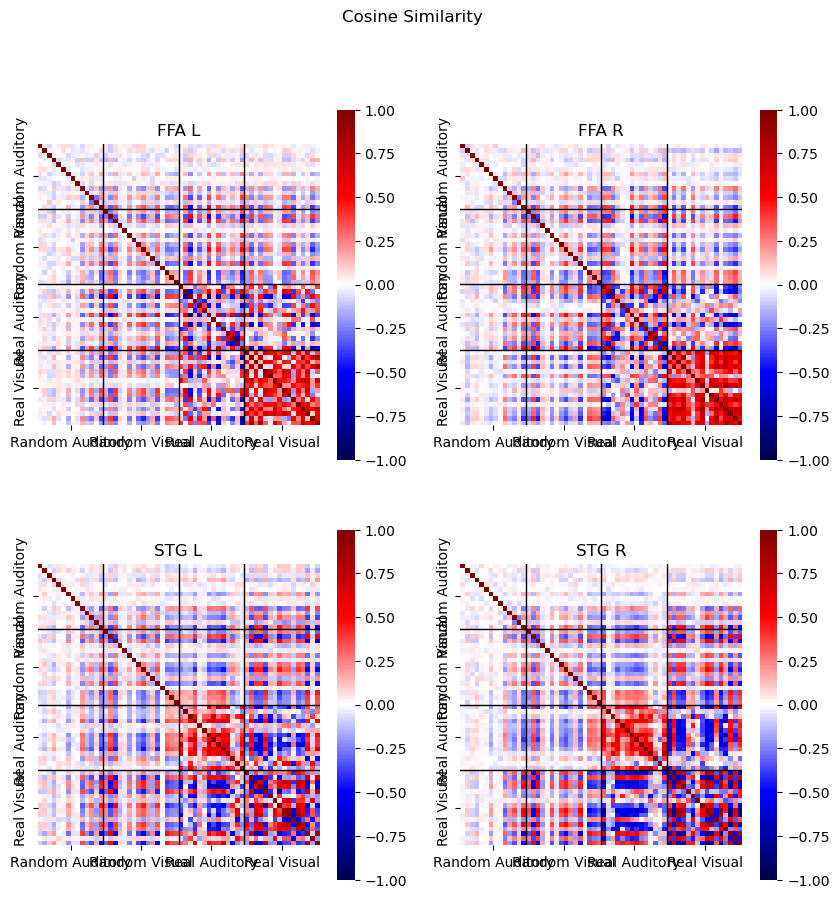

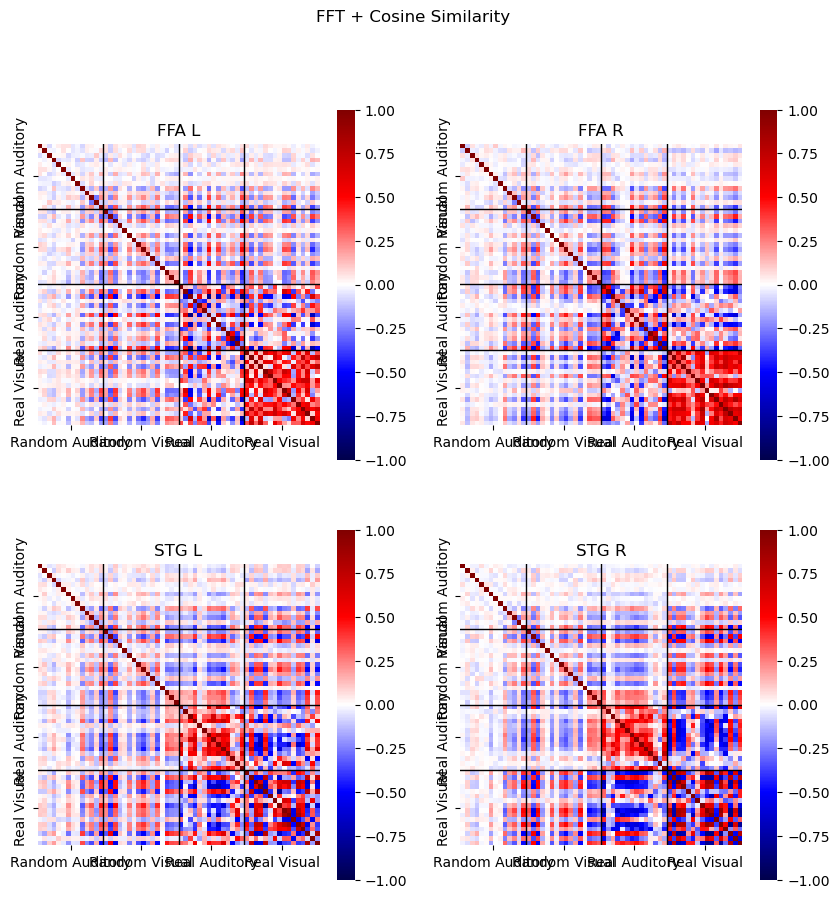

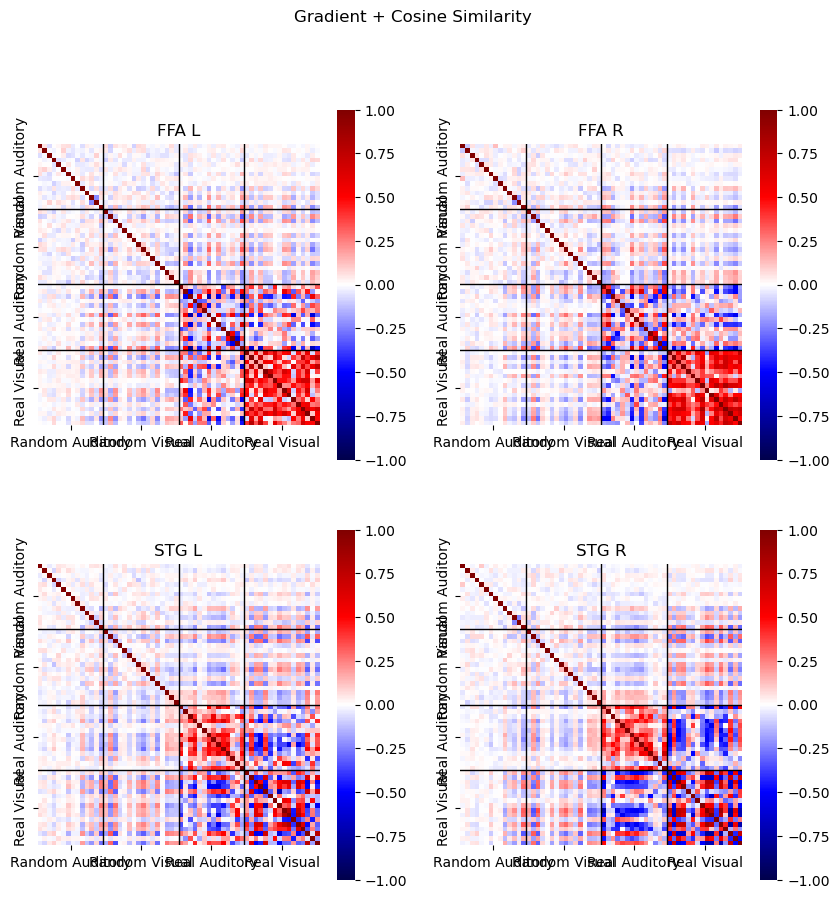

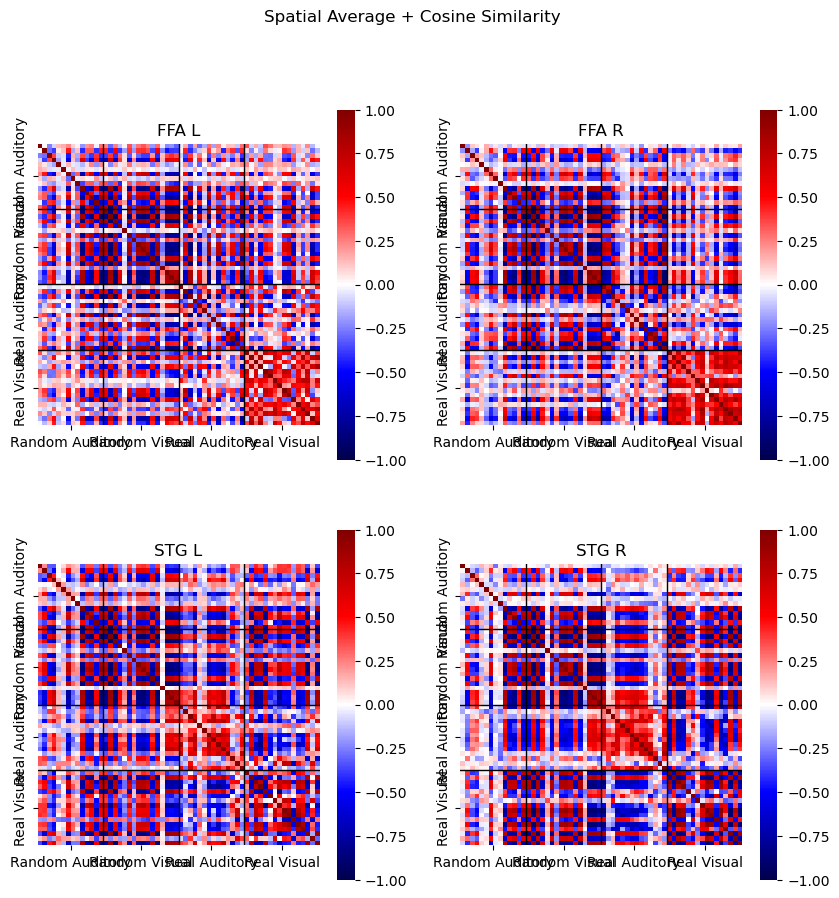

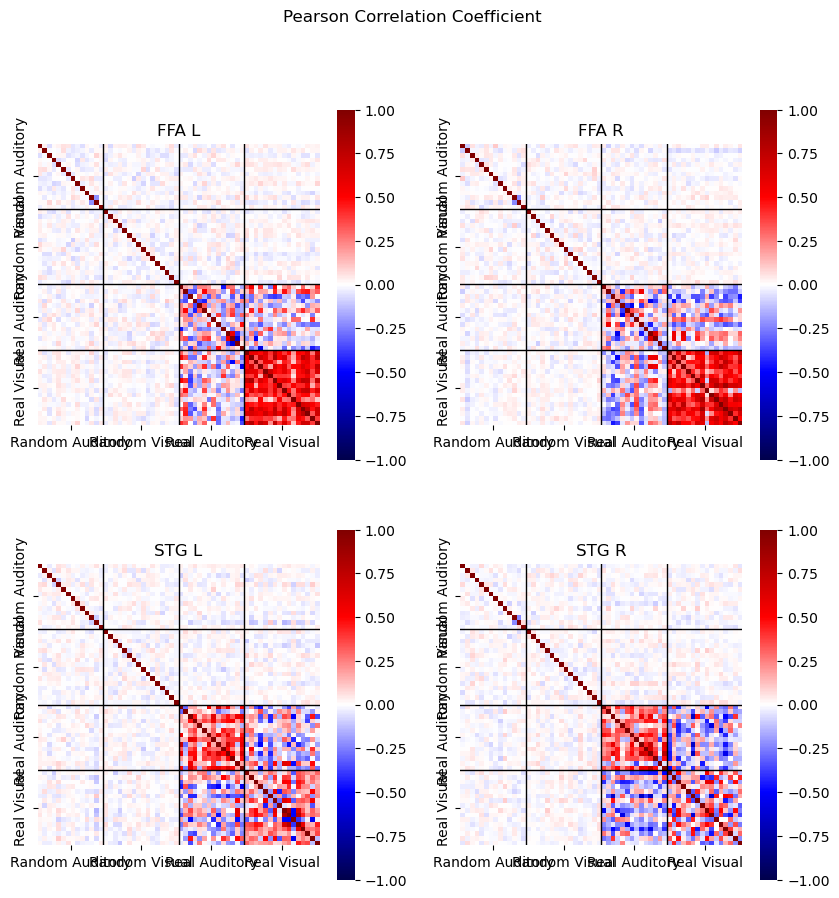

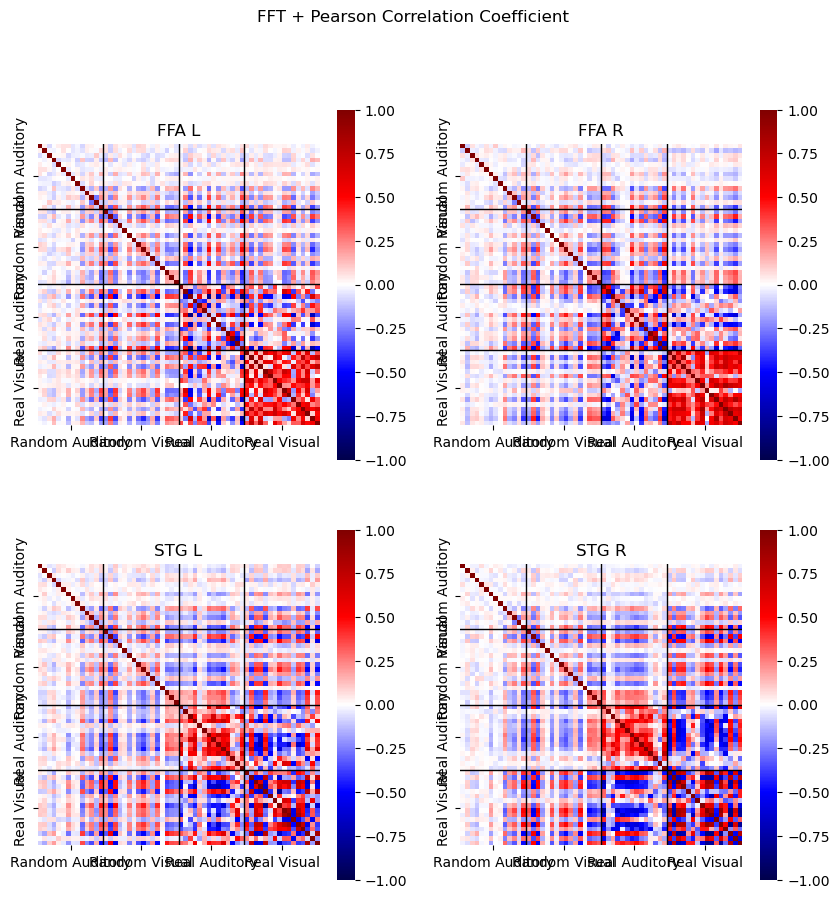

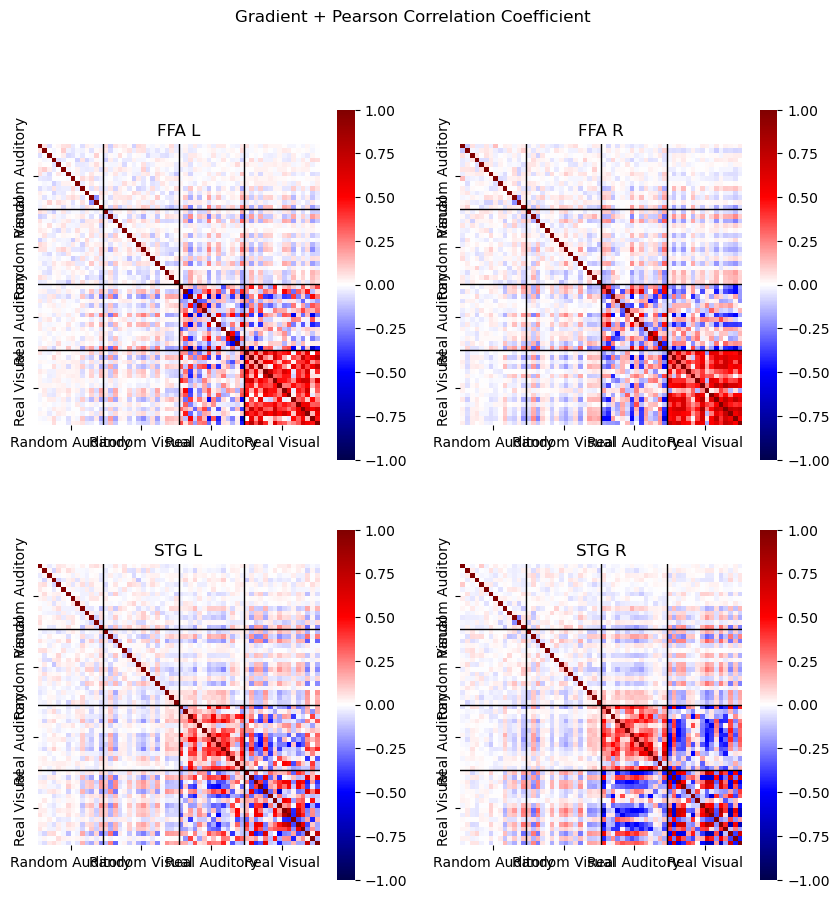

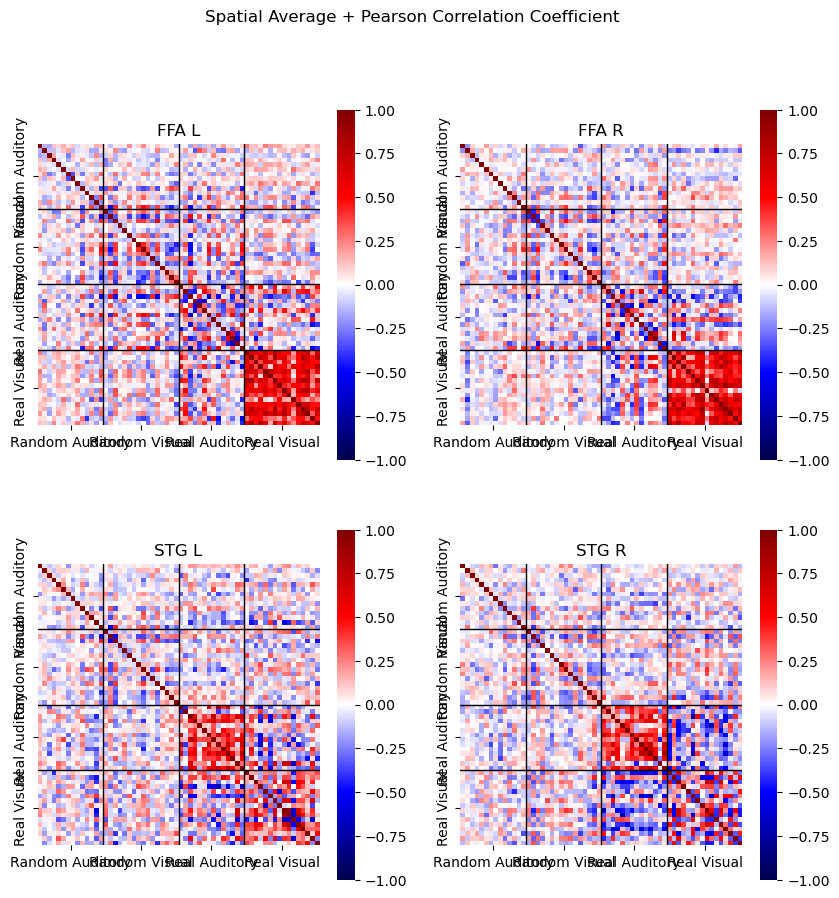

In [9]:
FIGSIZE = (10, 10)

for title, region_dict in similarity_mat_dict.items():
    fig = plt.figure(figsize=FIGSIZE)
    for ax_idx, region in enumerate(dataset.regions, start=1):
        ax = fig.add_subplot(2, 2, ax_idx)
        similarity_mat: toolkit.dataset.SimilarityMatrix = region_dict[region]
        ax = toolkit.plot.plot_similarity_heatmap(
            similarity_matrix=similarity_mat.matrix,
            title=f"{region}",
            ax=ax,
            slices_dict=similarity_mat.stimulation_slices,
            split_x=True,
            split_y=True,
            cbar=True
        )
    fig.suptitle(title)
    plt.show(fig)
    fig.savefig(os.path.join(generate_dirname, f"{title}_similarity_heatmap.svg"))

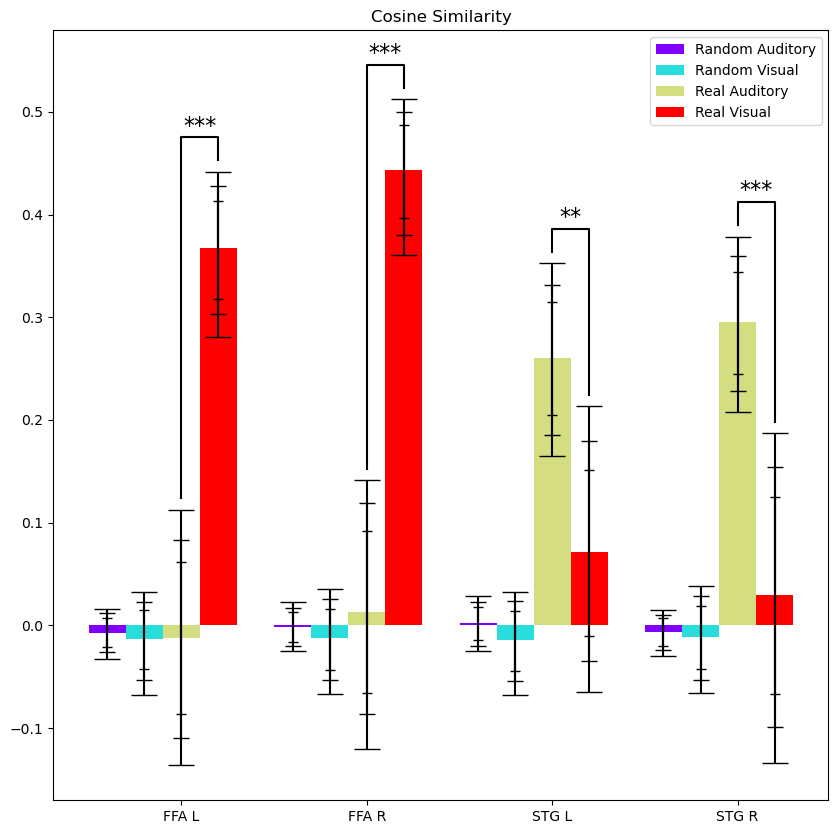

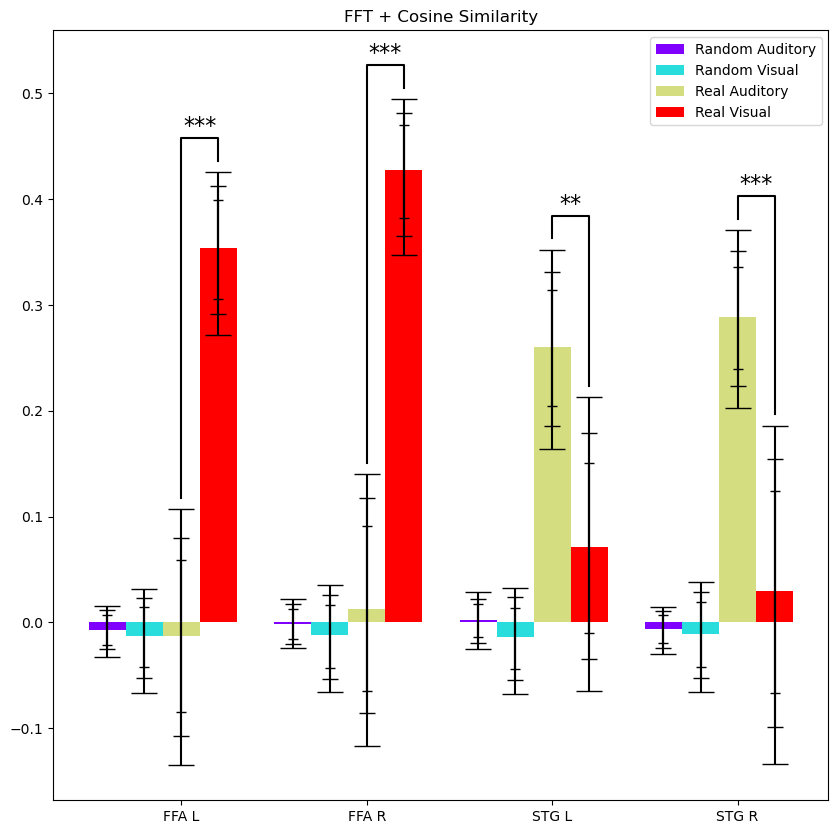

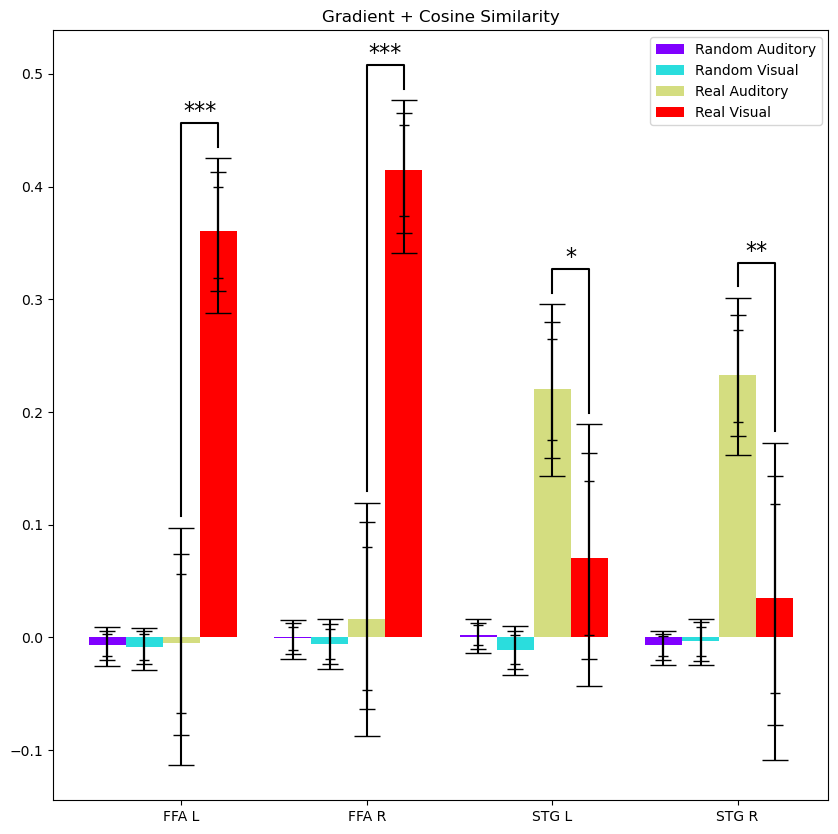

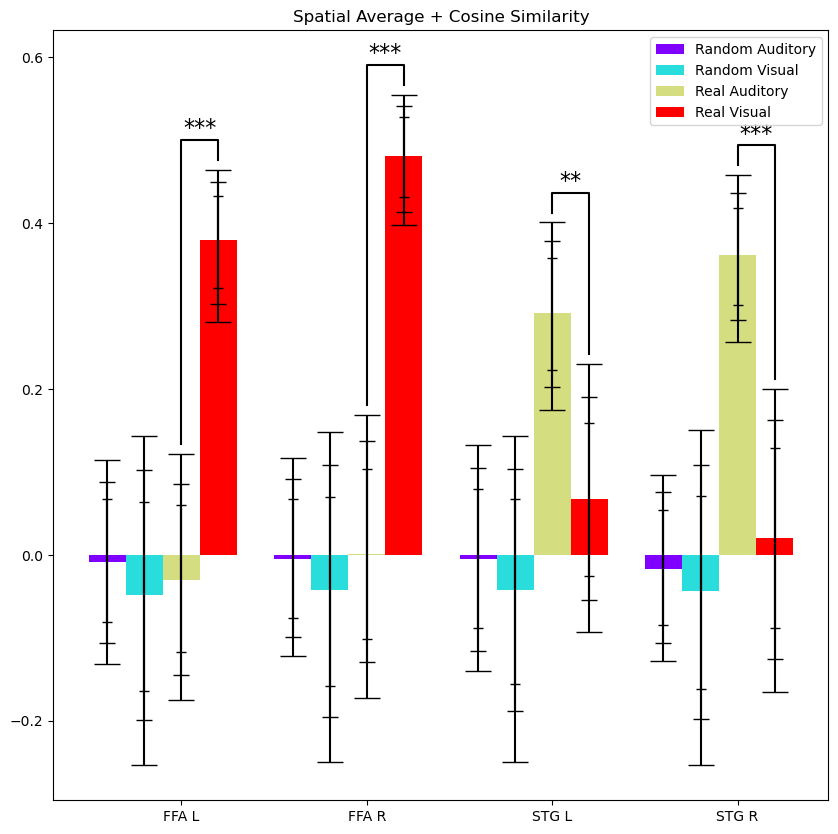

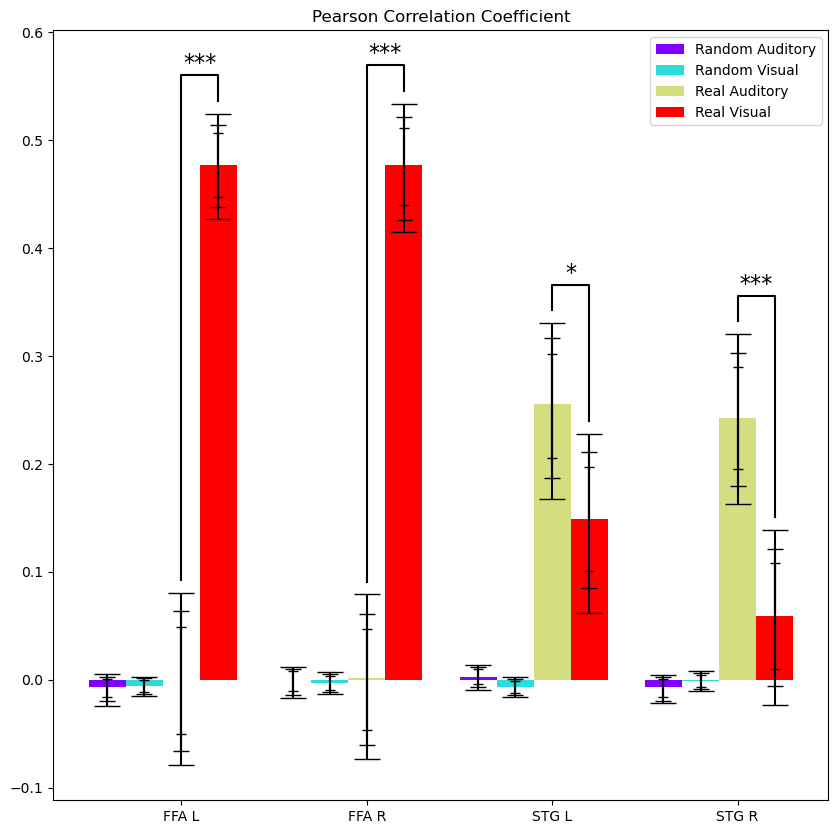

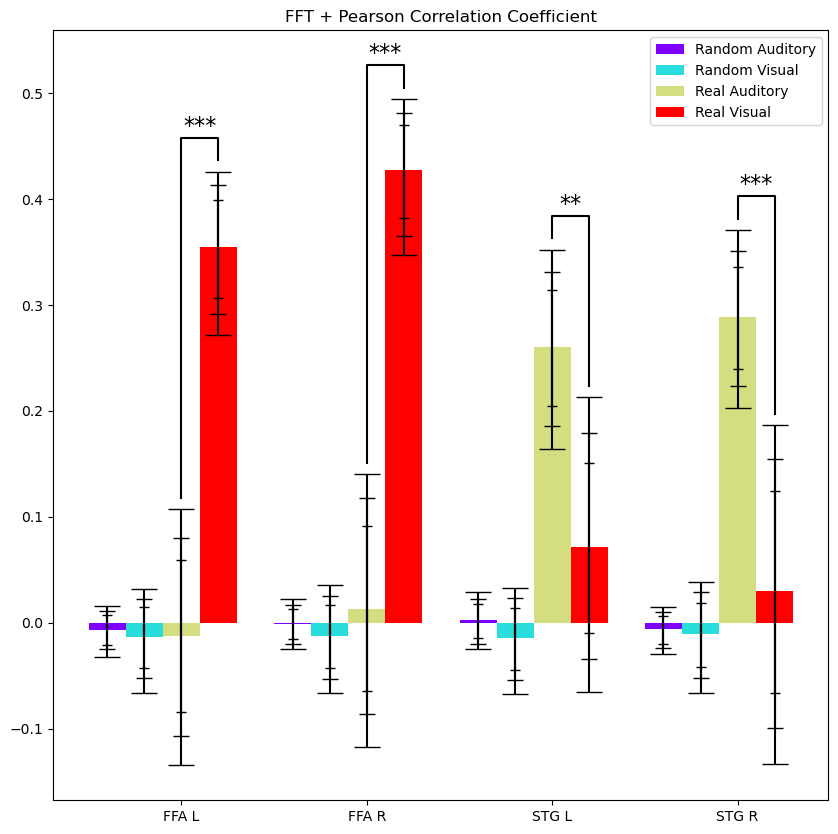

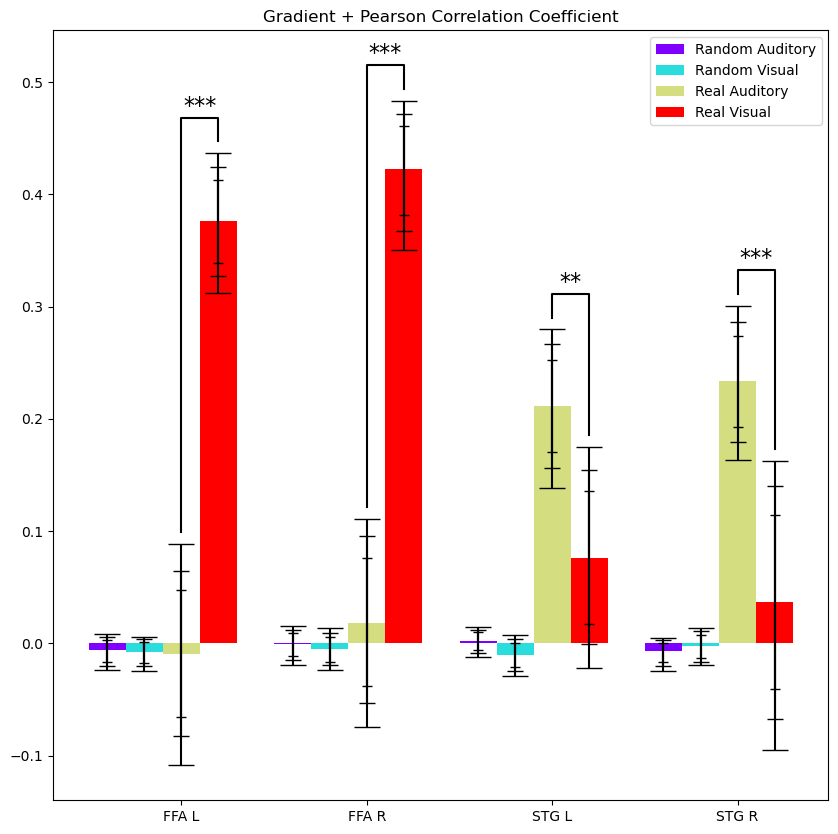

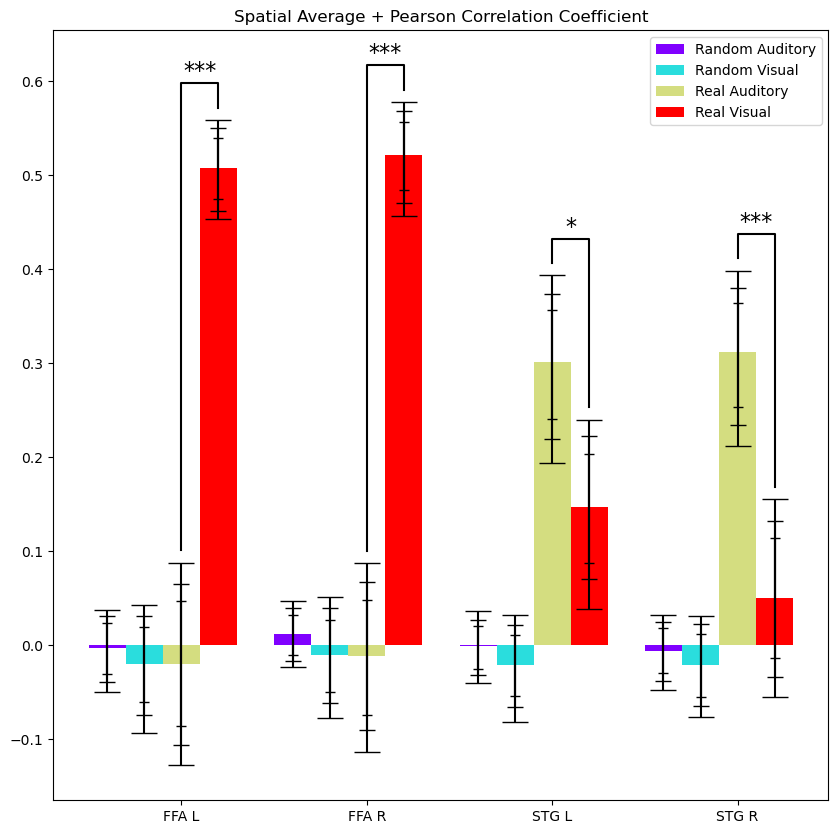

In [10]:
FIGSIZE = (10, 10)

test = toolkit.test.BootstrapTest()
for title, region_dict in similarity_mat_dict.items():
    # get the bars dict
    bar_idx = 0
    region_similarity_dict = {}
    region_pos = {}
    group_difference = []
    for region in dataset.regions:
        similarity_mat: toolkit.dataset.SimilarityMatrix = region_dict[region]
        bar_start = bar_idx
        region_group_difference = []
        for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
            stimulation_similarity = []
            for subject_idx_1, subject_idx_2 in permutations(subject_idx_lst, 2):
                idx_1 = similarity_mat.subject_vectors[subject_idx_1].idx
                idx_2 = similarity_mat.subject_vectors[subject_idx_2].idx
                if idx_1 > idx_2:
                    stimulation_similarity.append(similarity_mat.matrix[idx_1, idx_2])
            stimulation_similarity = np.array(stimulation_similarity)
            stimulation_similarity = stimulation_similarity[np.newaxis, :]
            bootstrap_res = test(data=stimulation_similarity, 
                                 confidence_levels=["*", "**", "***"])
            label = f"{data_type} {stimulation}"
            region_similarity_dict[bar_idx] = (
                label,
                bootstrap_res.statistic,
                bootstrap_res.distribution,
                bootstrap_res.confidence_interval,
            )
            if data_type == "Real":
                region_group_difference.append(bar_idx)
            bar_idx += 1
        group_difference.append(tuple([*region_group_difference, 1]))
        bar_end = bar_idx
        tick_pos = (bar_start + bar_end) / 2
        region_pos[tick_pos] = region
        bar_idx += 1

    fig = plt.figure(figsize=FIGSIZE)
    ax = fig.add_subplot(1, 1, 1)
    ax = toolkit.plot.plot_distribution_barplot(
        data_dict=region_similarity_dict,
        ncolors=4,
        title=title,
        ax=ax,
        legend=True,
        show_labels=region_pos,
        # show_distribution=True,
        show_confidence_interval=["*", "**", "***"],
        show_group_difference=group_difference,
    )
    plt.show(fig)
    fig.savefig(os.path.join(generate_dirname, f"{title}_similarity_barplot.svg"))

### Scatter

In [ ]:
class ToLoc:
    auditory: int
    visual: int
    def __init__(self, auditory: int, visual: int):
        self.auditory = auditory
        self.visual = visual
stimulation_slices = get_slices()
similarity_loc_dict = {}
stimulation_to_loc_dict = {}
loc_lst: list[ToLoc] = []
for data_type_to, stimulation_to, _ in datatype_and_stimulations():
    if data_type_to == "Real":
        stimulation_slice: slice = stimulation_slices[f"{data_type_to} {stimulation_to}"]
        stimulation_to_loc_dict[stimulation_to] = list(range(stimulation_slice.start, stimulation_slice.stop))
for x, y in product(stimulation_to_loc_dict["Auditory"], stimulation_to_loc_dict["Visual"]):
    to_loc_tuple = ToLoc(auditory=x, visual=y)
    loc_lst.append(to_loc_tuple)
for data_type_from, stimulation_from, _ in datatype_and_stimulations():
    stimulation_slice: slice = stimulation_slices[f"{data_type_from} {stimulation_from}"]
    value_loc_lst = list(range(stimulation_slice.start, stimulation_slice.stop))
    similarity_loc_dict[f"{data_type_from} {stimulation_from}"] = [
        (value_loc, to_loc.auditory, to_loc.visual)
        for value_loc, to_loc in product(value_loc_lst, loc_lst)
    ]
colors = plt.cm.get_cmap("rainbow", 4)
for method, region_dict in similarity_mat_dict.items():
    print(method)
    fig, axs = plt.subplots(2, 2, figsize=FIGSIZE)
    axs = axs.flatten()
    for ax_idx, region in enumerate(dataset.regions):
        ax = axs[ax_idx]
        similarity_mat: toolkit.dataset.SimilarityMatrix = region_dict[region]
        for color_idx, (data_type, stimulation, _) in enumerate(datatype_and_stimulations()):
            similarity_loc_lst = similarity_loc_dict[f"{data_type} {stimulation}"]
            similarity_x = [
                similarity_mat.matrix[loc[0], loc[1]]
                for loc in similarity_loc_lst
            ]
            similarity_y = [
                similarity_mat.matrix[loc[0], loc[2]]
                for loc in similarity_loc_lst
            ]
            ax.scatter(
                similarity_x,
                similarity_y,
                label=f"{data_type} {stimulation}",
                color=colors(color_idx),
            )

### KMeans Clustering

In [11]:
clustering_accuracy_df = pd.DataFrame(columns=["Region", "Method", "Total Accuracy", "Specific Accuracy"])

stimulation_slices = get_slices()
real_indices = []
specific_indices_dict = {}
for data_type, stimulation, _ in datatype_and_stimulations():
    if data_type == "Real":
        stimulation_slice: slice = stimulation_slices[f"{data_type} {stimulation}"]
        indices_lst = list(range(stimulation_slice.start, stimulation_slice.stop))
        real_indices += indices_lst
        specific_indices_dict[stimulation] = indices_lst

for region in dataset.regions:
    print(f"Region: {region}")
    structure = toolkit.dataset.get_structure(region=region)
    match structure:
        case "FFA":
            specific_stimulation = "Visual"
        case "STG":
            specific_stimulation = "Auditory"
    specific_indices: list = specific_indices_dict[specific_stimulation]
    for method, region_dict in similarity_mat_dict.items():
        print(f"  Method: {method}")
        similarity_mat: toolkit.dataset.SimilarityMatrix = region_dict[region]
        matrix = similarity_mat.matrix.copy()
        for idx in specific_indices:
            self_idx = specific_indices.copy()
            self_idx.remove(idx)
            matrix[idx, idx] = np.mean(matrix[idx, self_idx])
        matrix = matrix[:, specific_indices]
        matrix = np.mean(matrix, axis=1, keepdims=True)
        # assume 2 clusters for specific and non-specific
        n_clusters = 2
        clusters_label = (0, 1)
        km_res = toolkit.clustering.kmeans_clustering(
            data=matrix, n_clusters=n_clusters)
        total_clusters = km_res.labels
        specific_clusters = km_res.labels[specific_indices]
        total_acc_score = -np.inf
        specific_acc_score = -np.inf
        for specific_label, non_specific_label in permutations(clusters_label, 2):
            target_total_clusters = np.full_like(total_clusters, non_specific_label)
            target_total_clusters[specific_indices] = specific_label
            target_specific_clusters = target_total_clusters[specific_indices]
            total_score = accuracy_score(target_total_clusters, total_clusters)
            specific_scoure = accuracy_score(target_specific_clusters, specific_clusters)
            total_acc_score = max(total_acc_score, total_score)
            specific_acc_score = max(specific_acc_score, specific_scoure)
        print(f"    - Total Accuracy: {total_acc_score}")
        print(f"    - Specific Accuracy: {specific_acc_score}")
        new_row = pd.Series(
            {
                "Region": region,
                "Method": method,
                "Total Accuracy": total_acc_score,
                "Specific Accuracy": specific_acc_score,
            }
        )
        clustering_accuracy_df = pd.concat([clustering_accuracy_df, new_row.to_frame().T], ignore_index=True)
clustering_accuracy_df.to_csv(os.path.join(generate_dirname, "clustering_accuracy.csv"), index=False)

Region: FFA L
  Method: Cosine Similarity
    - Total Accuracy: 0.9833333333333333
    - Specific Accuracy: 0.9375
  Method: FFT + Cosine Similarity
    - Total Accuracy: 0.9833333333333333
    - Specific Accuracy: 0.9375
  Method: Gradient + Cosine Similarity
    - Total Accuracy: 0.9833333333333333
    - Specific Accuracy: 0.9375
  Method: Spatial Average + Cosine Similarity
    - Total Accuracy: 0.9666666666666667
    - Specific Accuracy: 0.9375
  Method: Pearson Correlation Coefficient
    - Total Accuracy: 1.0
    - Specific Accuracy: 1.0
  Method: FFT + Pearson Correlation Coefficient
    - Total Accuracy: 0.9833333333333333
    - Specific Accuracy: 0.9375
  Method: Gradient + Pearson Correlation Coefficient
    - Total Accuracy: 1.0
    - Specific Accuracy: 1.0
  Method: Spatial Average + Pearson Correlation Coefficient
    - Total Accuracy: 0.9666666666666667
    - Specific Accuracy: 0.9375
Region: FFA R
  Method: Cosine Similarity
    - Total Accuracy: 0.9666666666666667
    -

## Extract Specific Patterns

In [12]:
pattern_dict = {}
for region in dataset.regions:
    structure = toolkit.dataset.get_structure(region=region)
    specific_data_type = "Real"
    match structure:
        case "FFA":
            specific_stimulation = "Visual"
        case "STG":
            specific_stimulation = "Auditory"
    data_lst = []
    for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
        if (data_type == specific_data_type) and (stimulation == specific_stimulation):
            for subject_idx in subject_idx_lst:
                subject_data = dataset.get_region_data(
                    subject_idx=subject_idx, region=region
                )
                data_lst.append(subject_data)
    pattern_dict[region] = toolkit.pattern_extractor.extract_mean_pattern(
        data_lst=data_lst
    )

In [13]:
method_idx_df = pd.DataFrame(columns=["Method", "idx"])

pattern_similarity_mat_dict = {}
for region, pattern in pattern_dict.items():
    structure = toolkit.dataset.get_structure(region=region)
    hemisphere = toolkit.dataset.get_hemisphere(region=region)
    stimulation_slices = get_slices()
    matrix = np.empty((len(func_dict), len(dataset.database)))
    for method_idx, (method, func) in enumerate(func_dict.items()):
        similarity_lst = []
        for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
            for subject_idx in subject_idx_lst:
                subject_data = dataset.get_region_data(
                    subject_idx=subject_idx, region=region
                )
                similarity_lst.append(func(subject_data, pattern))
        similarity_lst = np.array(similarity_lst)
        matrix[method_idx] = similarity_lst
        if method_idx not in method_idx_df["idx"].values:
            new_row = pd.Series({"Method": method, "idx": method_idx})
            method_idx_df = pd.concat([method_idx_df, new_row.to_frame().T], ignore_index=True)
    subject_vectors = {}
    idx = 0
    for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
        for subject_idx in subject_idx_lst:
            get_info = lambda info: dataset.database.loc[subject_idx, info]
            subject_vector = toolkit.dataset.SubjectSimilarityVector(
                subject_idx=subject_idx,
                data_type=get_info("data_type"),
                stimulation=get_info("stimulation"),
                structure=toolkit.dataset.get_structure(region=region),
                hemisphere=toolkit.dataset.get_hemisphere(region=region),
                subject=get_info("subject"),
                idx=idx,
                similarity_vector=matrix[:, idx],
            )
            subject_vectors[subject_idx] = subject_vector
            idx += 1
    pattern_similarity_mat = toolkit.dataset.SimilarityMatrix(
        matrix=matrix,
        region=region,
        structure=structure,
        hemisphere=hemisphere,
        stimulation_slices=stimulation_slices,
        subject_vectors=subject_vectors,
    )
    pattern_similarity_mat_dict[region] = pattern_similarity_mat
method_idx_df.to_csv(os.path.join(generate_dirname, "specific_pattern_similarity_method_idx.csv"), index=False)

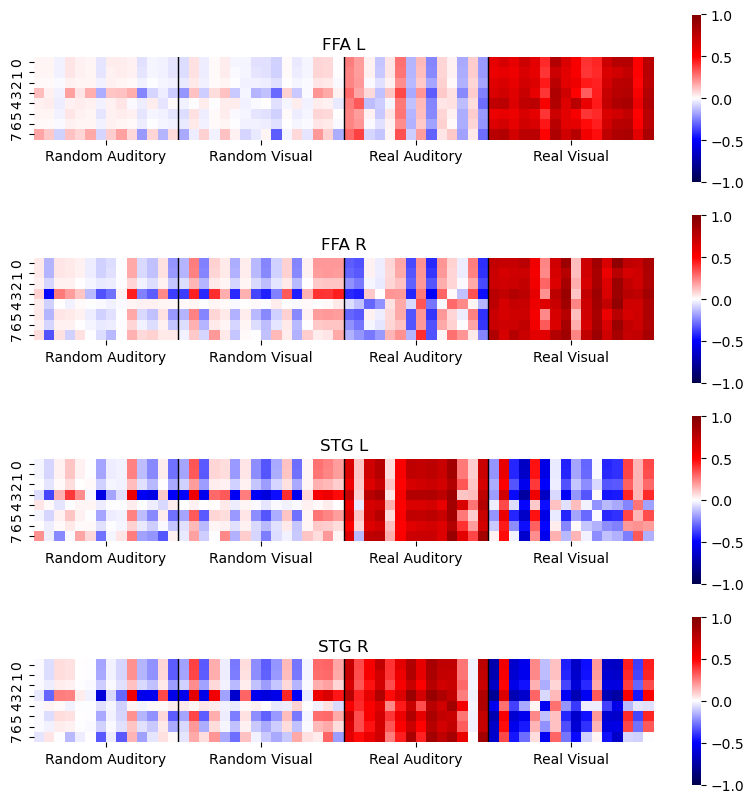

In [14]:
fig = plt.figure(figsize=FIGSIZE)
for ax_idx, region in enumerate(dataset.regions, start=1):
    ax = fig.add_subplot(4, 1, ax_idx)
    similarity_mat: toolkit.dataset.SimilarityMatrix = pattern_similarity_mat_dict[region]
    ax = toolkit.plot.plot_similarity_heatmap(
        similarity_matrix=similarity_mat.matrix,
        title=f"{region}",
        ax=ax,
        slices_dict=similarity_mat.stimulation_slices,
        split_x=True,
        split_y=False,
        cbar=True
    )
plt.show(fig)
fig.savefig(os.path.join(generate_dirname, "specific_pattern_similarity_heatmap.svg"))

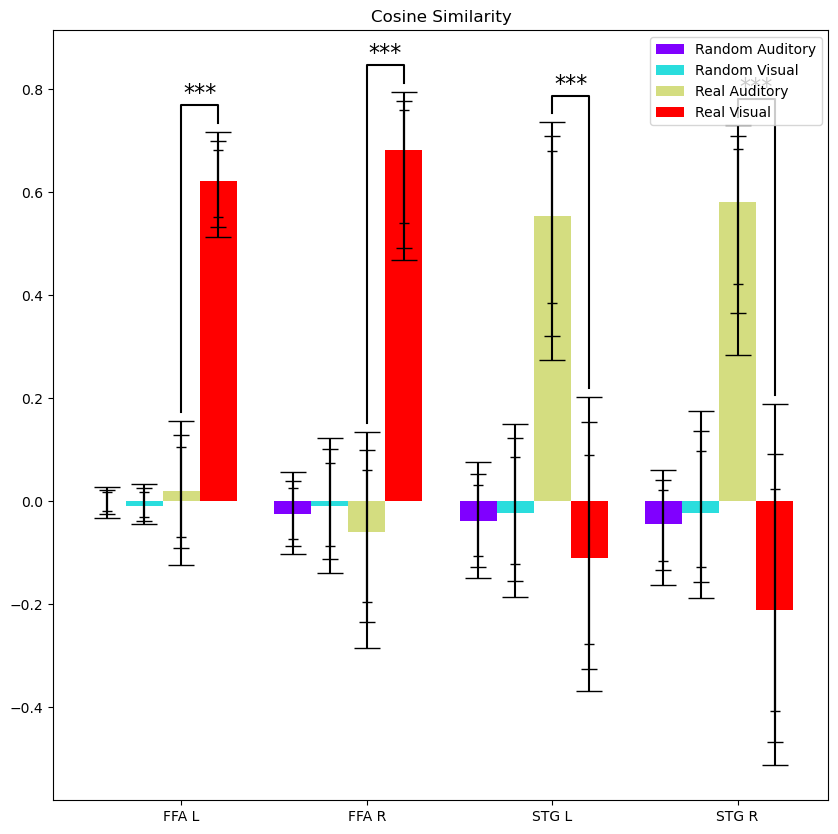

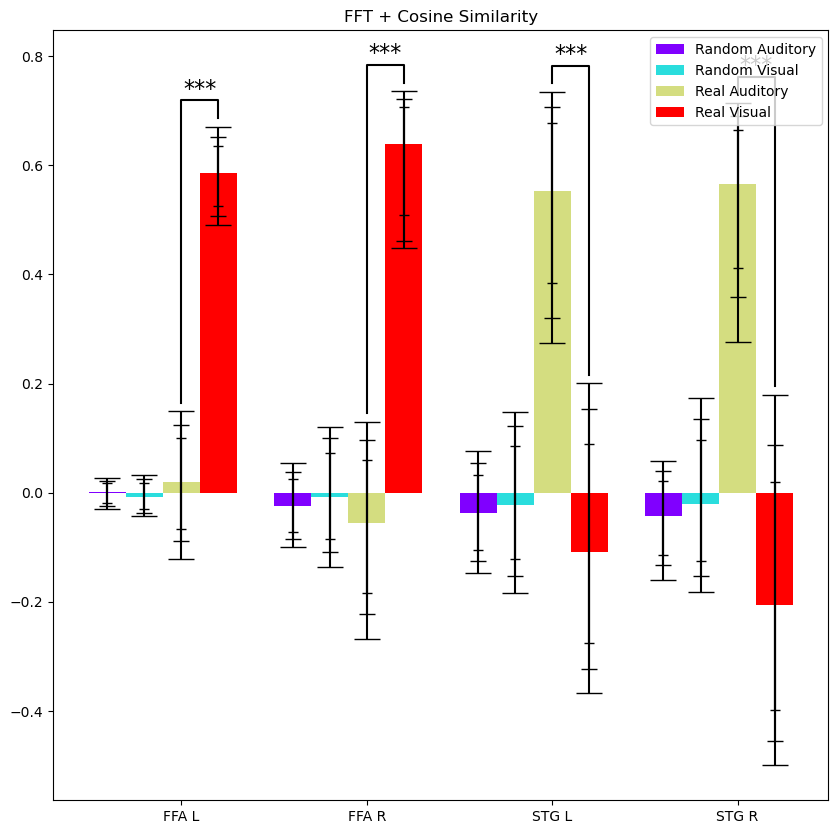

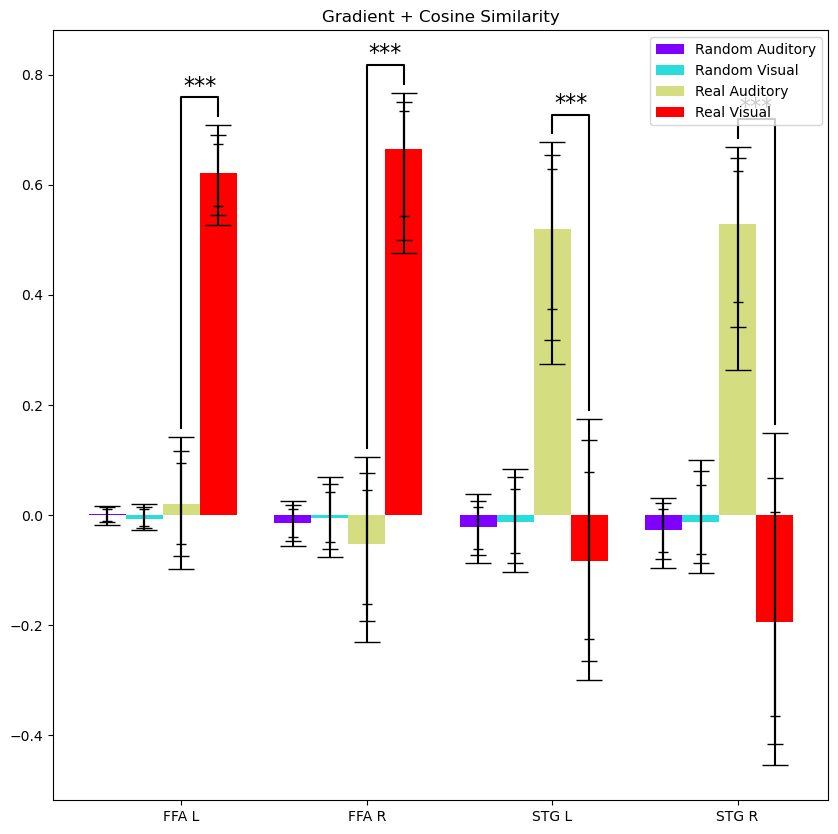

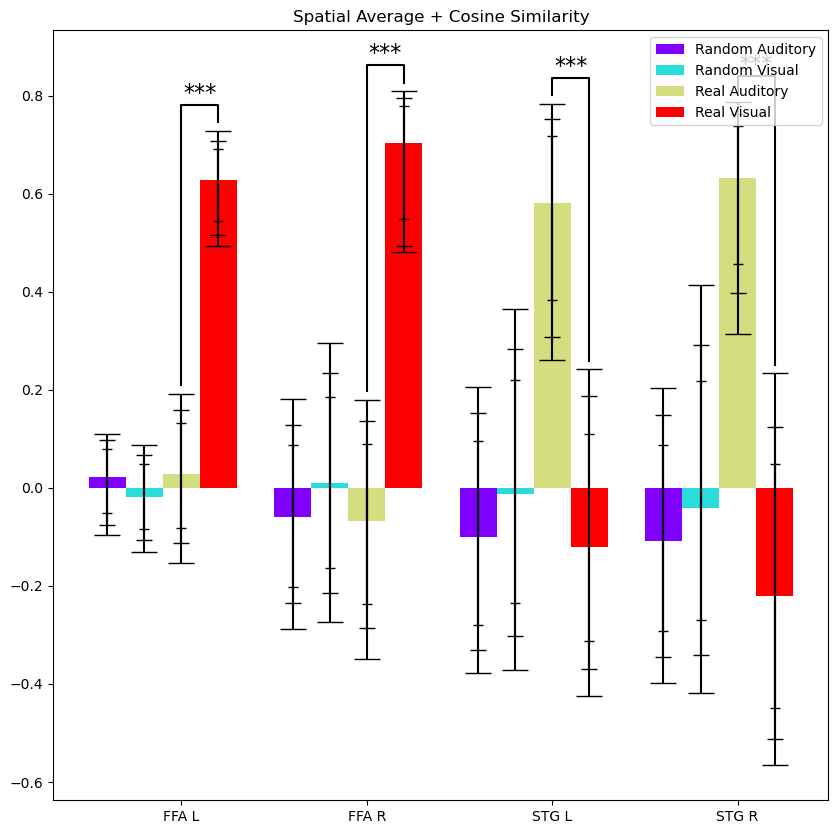

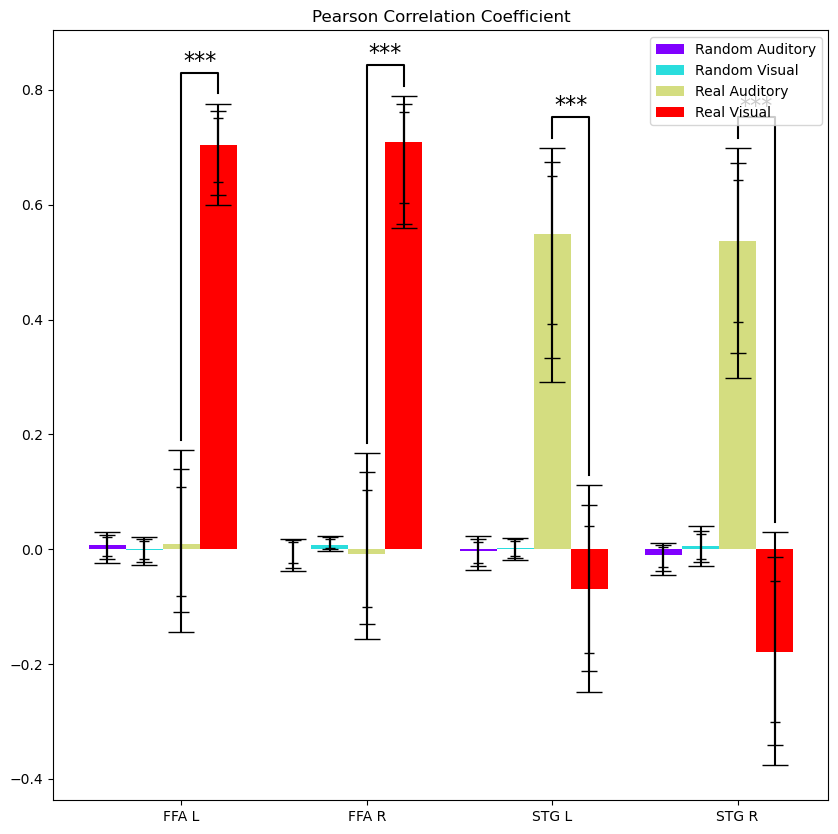

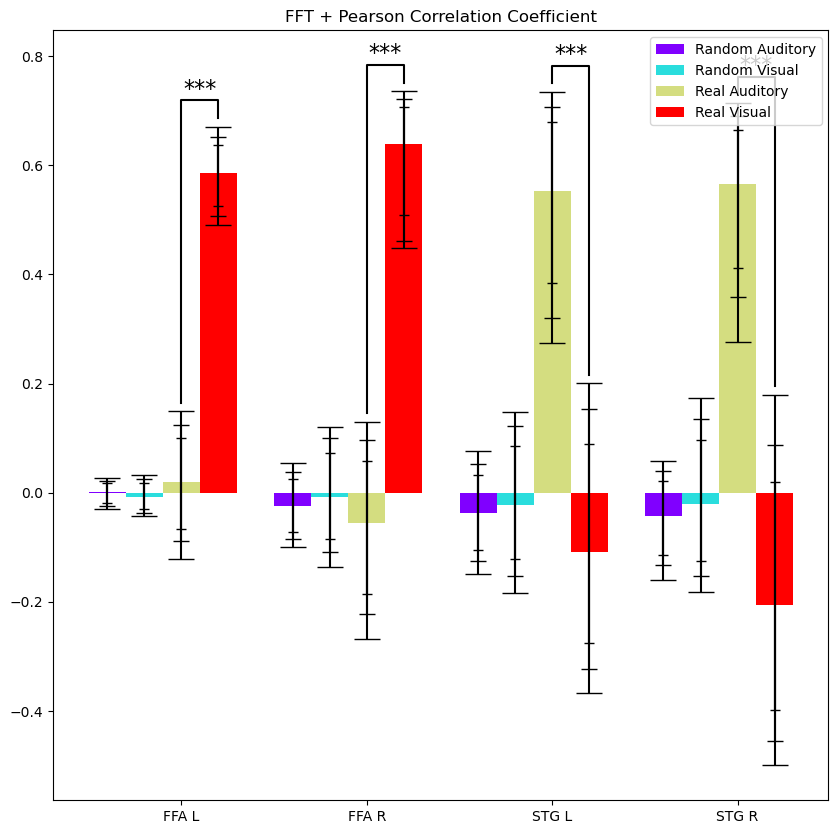

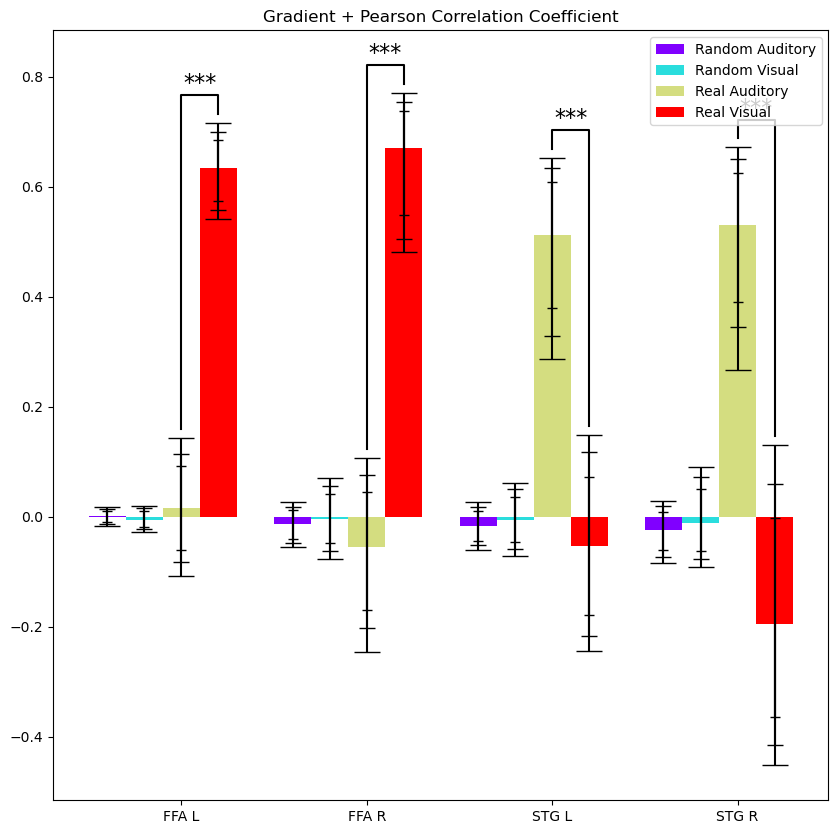

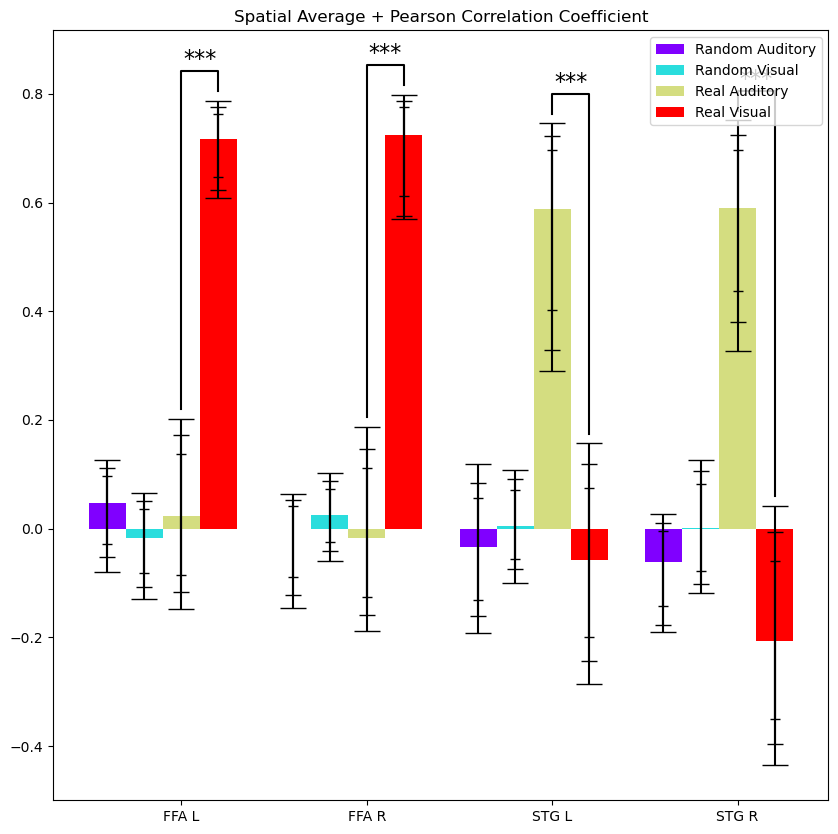

In [15]:
FIGSIZE = (10, 10)

test = toolkit.test.BootstrapTest()
for method_idx in range(len(method_idx_df)):
    method_name = method_idx_df.loc[method_idx, "Method"]
    # get the bars dict
    bar_idx = 0
    region_similarity_dict = {}
    region_pos = {}
    group_difference = []
    for region in dataset.regions:
        similarity_mat: toolkit.dataset.SimilarityMatrix = pattern_similarity_mat_dict[region]
        bar_start = bar_idx
        region_group_difference = []
        for data_type, stimulation, subject_idx_lst in datatype_and_stimulations():
            stimulation_similarity = []
            for subject_idx in subject_idx_lst:
                subject_vector = similarity_mat.subject_vectors[subject_idx]
                stimulation_similarity.append(subject_vector.similarity_vector[method_idx])
            stimulation_similarity = np.array(stimulation_similarity)
            stimulation_similarity = stimulation_similarity[np.newaxis, :]
            bootstrap_res = test(data=stimulation_similarity, 
                                 confidence_levels=["*", "**", "***"])
            label = f"{data_type} {stimulation}"
            region_similarity_dict[bar_idx] = (
                label,
                bootstrap_res.statistic,
                bootstrap_res.distribution,
                bootstrap_res.confidence_interval,
            )
            if data_type == "Real":
                region_group_difference.append(bar_idx)
            bar_idx += 1
        group_difference.append(tuple([*region_group_difference, 1]))
        bar_end = bar_idx
        tick_pos = (bar_start + bar_end) / 2
        region_pos[tick_pos] = region
        bar_idx += 1

    fig = plt.figure(figsize=FIGSIZE)
    ax = fig.add_subplot(1, 1, 1)
    ax = toolkit.plot.plot_distribution_barplot(
        data_dict=region_similarity_dict,
        ncolors=4,
        title=method_name,
        ax=ax,
        legend=True,
        show_labels=region_pos,
        show_confidence_interval=["*", "**", "***"],
        show_group_difference=group_difference,
    )
    plt.show(fig)
    fig.savefig(os.path.join(generate_dirname, f"{method_name}_specific_pattern_similarity_barplot.svg"))